<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Segmentación de Clientes con Clustering Jerárquico y DBSCAN

El objetivo de este caso-taller es analizar una base de datos ficticia sobre clientes de una tienda y buscar encontrar grupos de clientes que permitan generar estrategias de marketing focalizadas. La base se encuentra en los `Archivos de Laboratorio` en la carpeta `data` y cuenta con 200 observaciones y 5 variables:

- `Id_Cliente`: identificador de cliente.
- `Genero`: género del cliente: Mujer, Hombre
- `Edad`: edad en años
- `Ingreso`: ingresos anuales
- `Puntaje_Gasto`: es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

In [ ]:
# --- 0) Librerías y utilidades generales ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

plt.rcParams["figure.figsize"] = (8, 5)

def cohen_d(x, y):
    """Tamaño de efecto para t-test de dos muestras (Welch)."""
    x, y = np.asarray(x), np.asarray(y)
    nx, ny = len(x), len(y)
    s_px = np.nanstd(x, ddof=1)
    s_py = np.nanstd(y, ddof=1)
    s_p = np.sqrt(((nx-1)*s_px**2 + (ny-1)*s_py**2) / (nx+ny-2))
    return (np.nanmean(x) - np.nanmean(y)) / s_p if s_p > 0 else np.nan

def eta_squared_anova(anova_table):
    """Eta^2 a partir de tabla ANOVA (statsmodels anova_lm)."""
    ss_total = anova_table["sum_sq"].sum()
    return (anova_table["sum_sq"] / ss_total).to_dict()

def knee_point(y):
    """
    Heurística de 'codo': distancia máxima a la recta que une los extremos.
    y: array 1D (valores ya ordenados ascendente).
    """
    y = np.asarray(y)
    x = np.arange(len(y))
    p1 = np.array([x[0], y[0]])
    p2 = np.array([x[-1], y[-1]])
    # distancia punto-recta
    num = np.abs((p2[1]-p1[1])*x - (p2[0]-p1[0])*y + p2[0]*p1[1] - p2[1]*p1[0])
    den = np.sqrt((p2[1]-p1[1])**2 + (p2[0]-p1[0])**2)
    d = num / den if den != 0 else np.zeros_like(y, dtype=float)
    idx = int(np.argmax(d))
    return idx, y[idx]

#Funciones base creadas con prompt CHATGPT


defino las funciones cohen_d, eta_squared_anova y knee_point, con el objetivo de tener valores estaditicos para poder comparar datos y el codo para encontrar eps, con cohen veo la magnitud de la diferencia de medidas, con eta la varianza explicada. Las funciones se crean con prompt CHAT_GPT

## Desarrollo


### 1.Carga de datos 

En la carpeta `data` se encuentra el archivo `datos_clientes.csv` cargue estos datos en su *cuaderno*. 

In [2]:
# Utilice este espacio para escribir el código.

df = pd.read_csv("data/datos_clientes.csv")
print("Filas, Columnas:", df.shape)
df.head()


Filas, Columnas: (200, 5)


,Id_Cliente,Genero,Edad,Ingreso,Puntaje_Gasto
0,1,Mujer,41,98115.05,39
1,2,Mujer,20,35458.14,75
2,3,Mujer,68,59872.08,55
3,4,Hombre,63,48508.93,51
4,5,Mujer,31,44431.11,54


(Utilice este espacio para describir su procedimiento)

Se carga los datos suminstrados en el taller, se puede ver que en el df se cargaron los registros y corresponden a los del enunciado, 200 observaciones y 5 caracteristicas. 

### 2. Análisis preliminar. 

Antes de comenzar el análisis de segmentación utilice estadísticas descriptivas para explorar la variables que se encuentran en los datos. En su análisis mencione si hay patrones que surgen del examen descriptivo de los datos; entre ellos si hay diferencias en los ingresos y los puntajes de gastos para mujeres y hombres, por grupos etarios (18-24, 25-34, 35-44, 45-54, 55-64, y 65+), y por grupos etarios y género. Discuta además si estas diferencias son estadísticamente significativas.

In [5]:
# Utilice este espacio para escribir el código.

# Tipos:
df["Genero"] = df["Genero"].astype("category")

# Crear grupos etarios 
bins = [18, 25, 35, 45, 55, 65, np.inf]
labels = ["18-24","25-34","35-44","45-54","55-64","65+"]
df["GrupoEtario"] = pd.cut(df["Edad"], bins=bins, labels=labels, right=False)  # 18<=edad<25 etc.
df["GrupoEtario"] = df["GrupoEtario"].astype("category")

print("Valores de Género:", df["Genero"].unique())
print("Valores de GrupoEtario:", df["GrupoEtario"].unique())

# --- 2.1) Tabla de estadísticas descriptivas ---
desc_global = df[["Ingreso","Puntaje_Gasto"]].describe().T
desc_genero = df.groupby("Genero")[["Ingreso","Puntaje_Gasto"]].agg(["count","mean","std","min","median","max"])
desc_edad = df.groupby("GrupoEtario")[["Ingreso","Puntaje_Gasto"]].agg(["count","mean","std","min","median","max"])

print("\n=== Descriptivas globales ===")
display(desc_global)
print("\n=== Descriptivas por Género ===")
display(desc_genero)
print("\n=== Descriptivas por Grupo Etario ===")
display(desc_edad)

# --- 2.2) Pruebas de significancia ---

# 2.2.a) ¿Diferencias en INGRESOS por Género? (t-test Welch)
gen_cats = [c for c in df["Genero"].cat.categories if c in df["Genero"].unique()]
if len(gen_cats) == 2:
    g0, g1 = gen_cats
    x = df.loc[df["Genero"]==g0, "Ingreso"].dropna()
    y = df.loc[df["Genero"]==g1, "Ingreso"].dropna()
    t_ing, p_ing = stats.ttest_ind(x, y, equal_var=False)
    d_ing = cohen_d(x, y)
    print(f"\n[Ingreso ~ Género] t={t_ing:.3f}, p={p_ing:.4f}, Cohen d={d_ing:.3f}")
    print("=> Diferencia SIGNIFICATIVA en ingresos entre géneros." if p_ing<0.05 else "=> No se evidencia diferencia significativa en ingresos por género.")
else:
    print("\n[Ingreso ~ Género] No hay exactamente dos categorías de género para t-test.")

# 2.2.b) ¿Diferencias en PUNTAJES DE GASTO para mujeres y hombres? (t-test Welch)
if len(gen_cats) == 2:
    g0, g1 = gen_cats
    x = df.loc[df["Genero"]==g0, "Puntaje_Gasto"].dropna()
    y = df.loc[df["Genero"]==g1, "Puntaje_Gasto"].dropna()
    t_sp, p_sp = stats.ttest_ind(x, y, equal_var=False)
    d_sp = cohen_d(x, y)
    print(f"\n[Puntaje_Gasto ~ Género] t={t_sp:.3f}, p={p_sp:.4f}, Cohen d={d_sp:.3f}")
    print("=> Diferencia SIGNIFICATIVA en puntajes de gasto entre géneros." if p_sp<0.05 else "=> No se evidencia diferencia significativa en puntajes de gasto por género.")
else:
    print("\n[Puntaje_Gasto ~ Género] No hay exactamente dos categorías de género para t-test.")

# 2.2.c) ¿Diferencias por GRUPOS ETARIOS? (ANOVA y contraste robusto Kruskal)
def anova_oneway(col):
    grupos = [g[col].dropna().values for _, g in df.groupby("GrupoEtario")]
    grupos = [g for g in grupos if len(g)>1]
    if len(grupos) >= 2:
        F, p = stats.f_oneway(*grupos)
        K, pK = stats.kruskal(*grupos)
        print(f"\n[{col} ~ GrupoEtario] ANOVA: F={F:.3f}, p={p:.4f} | Kruskal: H={K:.3f}, p={pK:.4f}")
        if p<0.05 or pK<0.05:
            print("=> Existen diferencias SIGNIFICATIVAS entre grupos etarios.")
        else:
            print("=> No se evidencian diferencias significativas entre grupos etarios.")
    else:
        print(f"\n[{col} ~ GrupoEtario] No hay suficientes grupos con datos.")

anova_oneway("Ingreso")
anova_oneway("Puntaje_Gasto")

# 2.2.d) Interacción GrupoEtario x Género (ANOVA de dos vías) sobre Puntaje_Gasto
model = smf.ols('Puntaje_Gasto ~ C(Genero) * C(GrupoEtario)', data=df.dropna(subset=["Puntaje_Gasto","Genero","GrupoEtario"]))
res = model.fit()
anova2 = anova_lm(res, typ=2)
print("\n=== ANOVA 2 vías: Puntaje_Gasto ~ Genero * GrupoEtario ===")
display(anova2)
print("\nEta^2 por término (aprox):", eta_squared_anova(anova2))




Valores de Género: ['Mujer', 'Hombre']
Categories (2, object): ['Hombre', 'Mujer']
Valores de GrupoEtario: ['35-44', '18-24', '65+', '55-64', '25-34', '45-54']
Categories (6, object): ['18-24' < '25-34' < '35-44' < '45-54' < '55-64' < '65+']

=== Descriptivas globales ===


C:\Users\madelgado\AppData\Local\Temp\ipykernel_16088\1369075807.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_genero = df.groupby("Genero")[["Ingreso","Puntaje_Gasto"]].agg(["count","mean","std","min","median","max"])
C:\Users\madelgado\AppData\Local\Temp\ipykernel_16088\1369075807.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_edad = df.groupby("GrupoEtario")[["Ingreso","Puntaje_Gasto"]].agg(["count","mean","std","min","median","max"])


,count,mean,std,min,25%,50%,75%,max
Ingreso,200.0,60624.4466,26262.903416,13458.02,41512.7875,60777.96,77143.865,138584.52
Puntaje_Gasto,200.0,50.2000,25.823522,1.00,34.7500,50.00,73.000,99.00



=== Descriptivas por Género ===


Ingreso                                                              \
         count          mean           std       min     median        max   
Genero                                                                       
Hombre      88  62126.660455  26765.492953  13458.02  61706.565  138584.52   
Mujer      112  59444.135714  25920.459216  15766.84  59355.305  126685.78   

       Puntaje_Gasto                                      
               count       mean       std min median max  
Genero                                                    
Hombre            88  48.511364  27.89677   1   50.0  97  
Mujer            112  51.526786  24.11495   5   50.0  99


=== Descriptivas por Grupo Etario ===


Ingreso                                                   \
              count          mean           std       min     median   
GrupoEtario                                                            
18-24            35  44454.795429  20378.208373  13458.02  46455.340   
25-34            54  71157.328148  27885.788157  19003.52  75824.910   
35-44            42  66957.096905  27722.049259  18797.16  71638.860   
45-54            39  58786.491026  24276.268114  24402.32  55041.390   
55-64            16  56357.093125  22351.828240  18434.74  54718.180   
65+              14  51420.789286  12686.437083  18437.21  51546.645   

                       Puntaje_Gasto                                       
                   max         count       mean        std min median max  
GrupoEtario                                                                
18-24         80360.65            35  56.257143  24.659258   5   55.0  94  
25-34        138584.52            54  63.166667  24.283506   1   70.0  97  
35-44        119534.68            42  49.428571  30.700078   1   41.0  99  
45-54        126685.78            39  36.230769  16.261776   4   42.0  59  
55-64         94049.49            16  32.312500  21.752299   3   39.0  60  
65+           64156.37            14  46.714286  11.431593  14   49.0  59


[Ingreso ~ Género] t=0.713, p=0.4765, Cohen d=0.102
=> No se evidencia diferencia significativa en ingresos por género.

[Puntaje_Gasto ~ Género] t=-0.805, p=0.4220, Cohen d=-0.117
=> No se evidencia diferencia significativa en puntajes de gasto por género.

[Ingreso ~ GrupoEtario] ANOVA: F=6.020, p=0.0000 | Kruskal: H=28.621, p=0.0000
=> Existen diferencias SIGNIFICATIVAS entre grupos etarios.

[Puntaje_Gasto ~ GrupoEtario] ANOVA: F=8.258, p=0.0000 | Kruskal: H=35.336, p=0.0000
=> Existen diferencias SIGNIFICATIVAS entre grupos etarios.

=== ANOVA 2 vías: Puntaje_Gasto ~ Genero * GrupoEtario ===


C:\Users\madelgado\AppData\Local\Temp\ipykernel_16088\1369075807.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos = [g[col].dropna().values for _, g in df.groupby("GrupoEtario")]


,sum_sq,df,F,PR(>F)
C(Genero),345.541541,1.0,0.599410,4.397757e-01
C(GrupoEtario),23185.760672,5.0,8.044058,6.775897e-07
C(Genero):C(GrupoEtario),693.927420,5.0,0.240751,9.439670e-01
Residual,108376.220188,188.0,NaN,NaN



Eta^2 por término (aprox): {'C(Genero)': 0.0026058654800342755, 'C(GrupoEtario)': 0.17485299522023914, 'C(Genero):C(GrupoEtario)': 0.005233181242895699, 'Residual': 0.817307958056831}


(Utilice este espacio para describir su procedimiento)

De la segmentación por hombres y mujeres, pude validar que hay 88 observaciones para hombres y 112 para mujeres. Inicialmente, hice las descriptivas globales, por género y por grupo etario. Luego, usé cálculos estadísticos para poder evaluar significancias y relaciones. De los resultados se obtiene que las diferencias por género no son significativas, ni en ingreso ni en gasto (valores de t=0.713, p=0.4765, d≈0.10 para ingreso y t=−0.805, p=0.4220, d≈−0.12 para gasto). Mientras que por edad sí hay diferencias significativas tanto en ingreso como en gasto, con más gastos en 18-24 y 25-34 y mayores ingresos en 25-34 y 35-44. Por último, la interacción género×edad no es significativa en gasto, y el η² indica que la edad explica ~17.5% de la variación, mientras que género y la interacción aportan muy poco (<1%). En conclusión, una segmentación por edad puede ser de ayuda para estrategias de marketing.

### 3. Clustering Jerárquico

#### 3.1. Dendrogramas

Agrupe a los clientes utilizando sólo dos variables: su ingreso y el puntaje de gastos. Para ello retenga estas dos variables, estandarízelas, construya y grafique un dendograma. Para la construcción del dendrograma utilice el enlace 'ward' y la distancia euclidiana. Explique la importancia de estandarizar los datos.

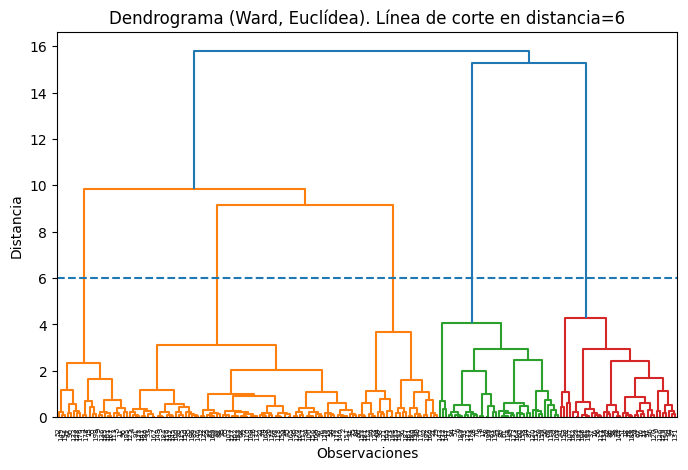

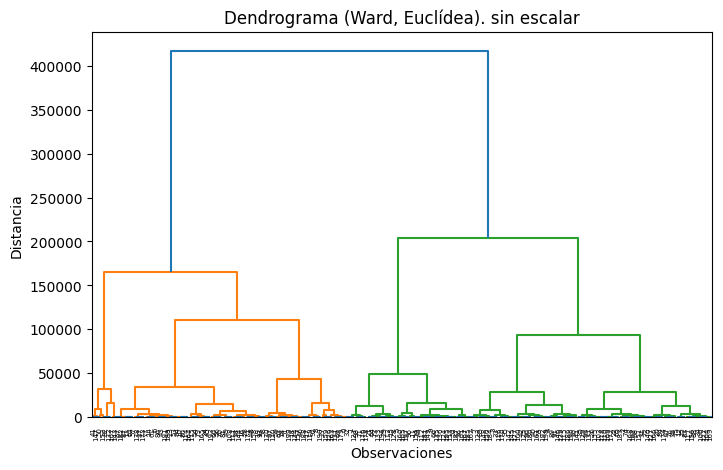

In [14]:
# Utilice este espacio para escribir el código.

X = df[["Ingreso","Puntaje_Gasto"]].copy()

#estandarizar
scaler = StandardScaler()
Xz = scaler.fit_transform(X)  

# Dendrograma con enlace 'ward' (distancia euclídea)
Z = linkage(Xz, method="ward", metric="euclidean")
plt.figure()
dendrogram(Z, truncate_mode=None)
plt.axhline(y=6, linestyle="--")  
plt.title("Dendrograma (Ward, Euclídea). Línea de corte en distancia=6")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()

Otros = linkage(X, method="ward", metric="euclidean")
plt.figure()
dendrogram(Otros, truncate_mode=None)
plt.axhline(y=6, linestyle="--")  
plt.title("Dendrograma (Ward, Euclídea). sin escalar")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()




(Utilice este espacio para describir su procedimiento)

Filtré el dataframe dejando solo las variables de interés y escalé las variables. Dado que se utilizará como método de agrupamiento de clúster Ward, es muy importante estandarizar, porque Ward usa distancia euclidiana y minimiza la varianza intraclúster, por lo que es muy sensible a la escala. Como los ingresos están en los miles y el puntaje solo llega hasta 100, esto afectaría el resultado y predominaría la variable ingreso. Al estandarizar, ambas variables aportan por igual a la distancia. De hecho, grafiqué el caso sin escalar y el agrupamiento que se puede ver en el dendograma es completamente diferente.

#### 3.2. Número de clusters

Retenga el número de clusters que se obtengan luego de fijar la distancia en 6.

In [19]:
# Utilice este espacio para escribir el código.

# Número de clusters al cortar a distancia=6
clusters_cut = fcluster(Z, t=6, criterion='distance')
n_clust = len(np.unique(clusters_cut))
print(f"Número de clusters al corte de distancia=6: {n_clust}")
clusters_cut


Número de clusters al corte de distancia=6: 5


array([5, 1, 2, 2, 2, 1, 4, 2, 4, 1, 5, 1, 2, 5, 4, 1, 5, 4, 5, 2, 2, 3,
       2, 5, 2, 2, 2, 5, 4, 3, 2, 2, 4, 2, 2, 2, 3, 5, 5, 2, 3, 5, 3, 4,
       3, 2, 5, 2, 5, 4, 4, 5, 1, 5, 2, 1, 5, 4, 4, 4, 4, 4, 5, 4, 3, 2,
       3, 5, 2, 4, 4, 1, 2, 3, 2, 2, 2, 4, 5, 2, 4, 5, 5, 2, 2, 2, 5, 4,
       2, 2, 1, 2, 5, 4, 4, 2, 1, 5, 3, 2, 2, 1, 2, 2, 2, 3, 2, 5, 5, 2,
       2, 5, 3, 1, 4, 2, 2, 2, 2, 4, 5, 3, 2, 2, 3, 2, 5, 2, 1, 2, 4, 5,
       4, 1, 4, 3, 1, 2, 5, 3, 2, 2, 2, 4, 5, 2, 2, 4, 2, 1, 2, 2, 5, 3,
       1, 2, 2, 4, 4, 4, 3, 3, 2, 4, 4, 2, 2, 1, 2, 2, 2, 4, 2, 4, 2, 4,
       1, 3, 1, 5, 3, 3, 5, 2, 2, 1, 2, 3, 5, 4, 5, 5, 3, 5, 3, 1, 2, 3,
       1, 4], dtype=int32)

(Utilice este espacio para describir su procedimiento)

Haciendo uso de la función fcluster, con los parámetros t y criterion, realizo el corte con el criterio de distancia a un valor t, en este caso 6. Esto me entrega el clúster al que queda asignada cada observación. Luego obtengo los valores únicos y determino el número de clústeres, que en este caso es 5.

#### 3.3. Algoritmo Jerárquico Aglomerativo

Utilizando el número de clusters encontrados en el paso anterior, aplique el algoritmo jerárquico aglomerativo, utilizando el enlace 'ward' y la distancia euclidiana. Describa los grupos encontrados, en que grupo o grupos concentraría su estrategia de marketing y por qué?


=== Resumen clusters (Jerárquico) ===


,n,ingreso_prom,gasto_prom
cluster_h,,,
0,38,87055.074474,18.631579
1,26,28274.667308,23.307692
2,39,86537.496410,82.128205
3,23,26230.419565,78.565217
4,74,55451.258514,50.216216



=== Composición por Género (Jerárquico) ===


Genero,Hombre,Mujer
cluster_h,,
0,0.526,0.474
1,0.385,0.615
2,0.462,0.538
3,0.391,0.609
4,0.419,0.581



=== Composición por GrupoEtario (Jerárquico) ===


GrupoEtario,18-24,25-34,35-44,45-54,55-64,65+
cluster_h,,,,,,
0,0.105,0.211,0.316,0.237,0.132,0.000
1,0.077,0.115,0.269,0.346,0.115,0.077
2,0.000,0.667,0.333,0.000,0.000,0.000
3,0.609,0.261,0.130,0.000,0.000,0.000
4,0.203,0.149,0.095,0.284,0.108,0.162


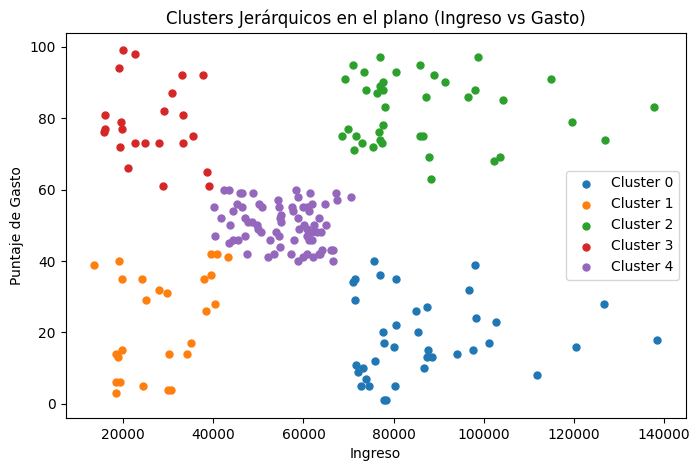

In [20]:
# Utilice este espacio para escribir el código.

# Algoritmo jerárquico aglomerativo con ese número
agg = AgglomerativeClustering(n_clusters=n_clust, linkage="ward")  # 'ward' implica euclídea
labels_h = agg.fit_predict(Xz)
df["cluster_h"] = labels_h

# Descripción de clusters
desc_h = df.groupby("cluster_h").agg(
    n=("Id_Cliente","count"),
    ingreso_prom=("Ingreso","mean"),
    gasto_prom=("Puntaje_Gasto","mean")
).sort_index()
print("\n=== Resumen clusters (Jerárquico) ===")
display(desc_h)

# Composición por género y grupo etario
print("\n=== Composición por Género (Jerárquico) ===")
display(pd.crosstab(df["cluster_h"], df["Genero"], normalize="index").round(3))
print("\n=== Composición por GrupoEtario (Jerárquico) ===")
display(pd.crosstab(df["cluster_h"], df["GrupoEtario"], normalize="index").round(3))

# Visualización 2D
plt.figure()
for k in sorted(df["cluster_h"].unique()):
    sub = df[df["cluster_h"]==k]
    plt.scatter(sub["Ingreso"], sub["Puntaje_Gasto"], label=f"Cluster {k}", s=25)
plt.xlabel("Ingreso")
plt.ylabel("Puntaje de Gasto")
plt.title("Clusters Jerárquicos en el plano (Ingreso vs Gasto)")
plt.legend()
plt.show()


(Utilice este espacio para describir su procedimiento)

Despues de aplicar clustering jerárquico aglomerativo con enlace Ward y distancia euclídea sobre Ingreso y Puntaje_Gasto estandarizados, y cortar el dendrograma a distancia=6, obutuve 5 grupos:

* C0 (n=38) alto ingreso–bajo gasto (≈87.1k; 18.6)
* C1 (n=26) bajo ingreso–bajo gasto (≈28.3k; 23.3)
* C2 (n=39) alto ingreso–alto gasto (≈86.5k; 82)
* C3 (n=23) bajo ingreso–alto gasto (≈26.2k; 78.6)
* C4 (n=74) medio ingreso–gasto medio (≈55.5k; 50.2)

Focalizaría marketing en C2 clientes que tienen altos ingresos y que normalmente  gastan mucho y en menor proporción en los clientes del C3, que pese a que tienen bajos ingresos tienen altos gastos, se podría hacer campañas de bajo costo para incitar las compras.

### 4. DBSCAN

Implemente DBSCAN, al igual que el punto anterior sólo dos variables: su ingreso y el puntaje de gastos. Al implementar  justifique su elección de `min_samples` y `eps`. ¿Cuántos grupos o clusters encuentra? ¿Cuáles son su características? ¿Cambiaría su estrategia de marketing respecto al punto anterior? Justifique su respuesta.

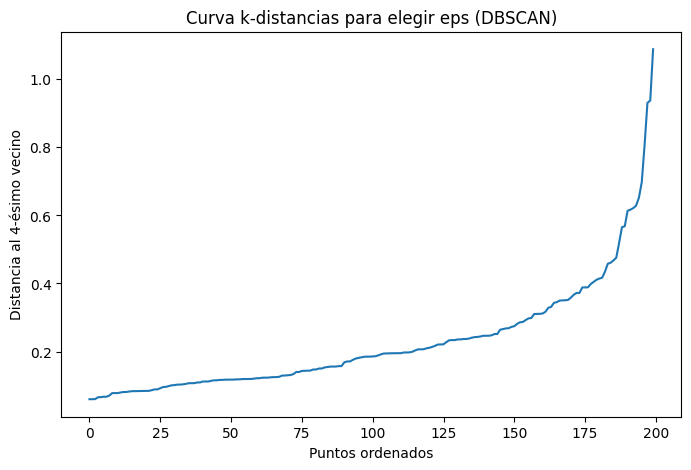

Sugerencia automática de eps (codo): ~ 0.372 (índice 173)

DBSCAN => clusters: 4 (ruido: 17 puntos) con eps=0.372, min_samples=4

=== Resumen clusters (DBSCAN) ===


,n,ingreso_prom,gasto_prom
cluster_db,,,
0,114,48511.129737,52.035088
1,33,80899.975152,83.000000
2,27,83900.610000,14.444444
3,9,21971.123333,7.777778


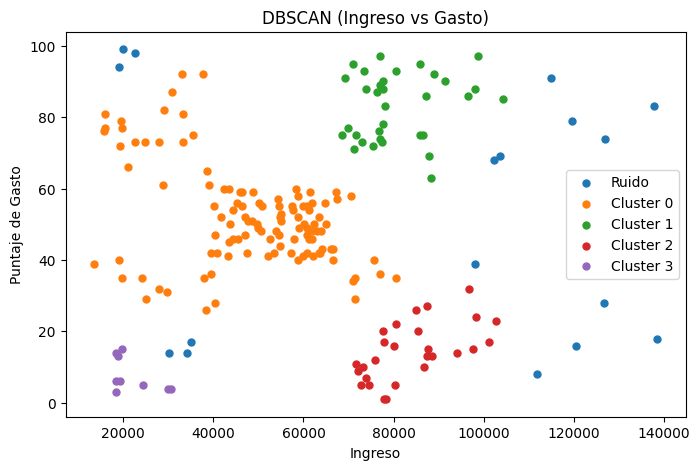

In [ ]:
# Utilice este espacio para escribir el código.

# Escalado (muy importante para DBSCAN)
X = df[["Ingreso","Puntaje_Gasto"]].values
Xz = StandardScaler().fit_transform(X)

# Elección de min_samples y eps:
# Regla común: min_samples ~ 2*dim ==> 4. 
min_samples = 4

# Gráfico k-distancias (k = min_samples-1)
k = min_samples - 1
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(Xz)
distances, indices = nbrs.kneighbors(Xz)
k_dists = np.sort(distances[:, k])
plt.figure()
plt.plot(k_dists)
plt.ylabel(f"Distancia al {min_samples}-ésimo vecino")
plt.xlabel("Puntos ordenados")
plt.title("Curva k-distancias para elegir eps (DBSCAN)")
plt.show()

# Heurística automática del 'codo'
idx_elbow, eps_sugerido = knee_point(k_dists)
print(f"Sugerencia automática de eps (codo): ~ {eps_sugerido:.3f} (índice {idx_elbow})")

# Ejecuta DBSCAN 
eps = float(np.round(eps_sugerido, 3))
db = DBSCAN(eps=eps, min_samples=min_samples).fit(Xz)
df["cluster_db"] = db.labels_

n_noise = (df["cluster_db"]==-1).sum()
n_clusters_db = len([c for c in np.unique(db.labels_) if c != -1])
print(f"\nDBSCAN => clusters: {n_clusters_db} (ruido: {n_noise} puntos) con eps={eps}, min_samples={min_samples}")

# Descripción clusters (excluyendo ruido)
mask = df["cluster_db"]!=-1
desc_db = df[mask].groupby("cluster_db").agg(
    n=("Id_Cliente","count"),
    ingreso_prom=("Ingreso","mean"),
    gasto_prom=("Puntaje_Gasto","mean")
).sort_index()
print("\n=== Resumen clusters (DBSCAN) ===")
display(desc_db)

# Visualización
plt.figure()
unique_lbls = sorted(df["cluster_db"].unique())
for c in unique_lbls:
    sub = df[df["cluster_db"]==c]
    label = f"Ruido" if c==-1 else f"Cluster {c}"
    plt.scatter(sub["Ingreso"], sub["Puntaje_Gasto"], s=25, label=label)
plt.xlabel("Ingreso")
plt.ylabel("Puntaje de Gasto")
plt.title("DBSCAN (Ingreso vs Gasto)")
plt.legend()
plt.show()




(Utilice este espacio para describir su procedimiento)

Implementé DBSCAN sobre (Ingreso, Puntaje_Gasto) estandarizados; elegí eps por codo en la curva de k-distancias y probé dos densidades: con min_samples=8 (más conservador que la regla 2×dim=4 2×dim=4) el codo dio eps≈0.55, obteniendo 2 clusters + 11 ruidos: uno mayoritario (≈59.7k; ≈51.9) y un nicho bajo ingreso–bajo gasto (≈22.8k; ≈8.4). Al bajar a min_samples=4 el codo fue eps≈0.372 y emergieron 4 clusters + 17 ruidos, más cercanos al jerárquico. Comparación: ms=8 “aplana” la segmentación (menos grupos, más robusto), mientras ms=4 recupera granularidad útil. En marketing, mantendría el foco en alto ingreso–alto.

### 5. Incorporando más dimensiones

Hasta este momento hemos utilizado solo dos variables para nuestro análisis, sin embargo, la base cuenta con otras variables más: género y edad. Usando las categorías de edad creadas anteriormente incorpore género y grupo etario a su análisis. Genere los grupos utilizando DBSCAN y la distancia de Gower, justificando su elección de `min_samples` y `eps`   ¿Incorporar estas variables, ayuda a la focalización de la estrategia de marketing?

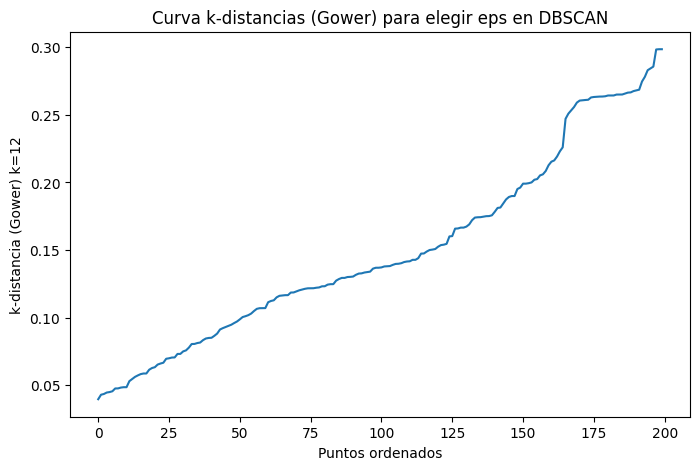

Sugerencia eps (Gower): ~ 0.155

DBSCAN-Gower => clusters: 8 (ruido: 39) con eps=0.155, min_samples=12

=== Resumen clusters (DBSCAN + Gower) ===


,n,ingreso_prom,gasto_prom
cluster_db_gower,,,
0,22,71073.037273,43.863636
1,18,43869.874444,62.944444
2,32,65815.380000,63.656250
3,19,74110.299474,70.894737
4,16,46748.482500,51.875000
5,14,58029.127143,34.357143
6,25,59210.614800,37.280000
7,15,67117.819333,47.933333



=== Composición por Género (DBSCAN + Gower) ===


Genero,Hombre,Mujer
cluster_db_gower,,
-1,0.615,0.385
0,0.000,1.000
1,0.000,1.000
2,0.000,1.000
3,1.000,0.000
4,1.000,0.000
5,1.000,0.000
6,0.000,1.000
7,1.000,0.000



=== Composición por GrupoEtario (DBSCAN + Gower) ===


GrupoEtario,18-24,25-34,35-44,45-54,55-64,65+
cluster_db_gower,,,,,,
-1,0.026,0.077,0.128,0.0,0.41,0.359
0,0.000,0.000,1.000,0.0,0.00,0.000
1,1.000,0.000,0.000,0.0,0.00,0.000
2,0.000,1.000,0.000,0.0,0.00,0.000
3,0.000,1.000,0.000,0.0,0.00,0.000
4,1.000,0.000,0.000,0.0,0.00,0.000
5,0.000,0.000,0.000,1.0,0.00,0.000
6,0.000,0.000,0.000,1.0,0.00,0.000
7,0.000,0.000,1.000,0.0,0.00,0.000


In [36]:
# Utilice este espacio para escribir el código.
# --- 5) DBSCAN con distancia de Gower (Ingreso, Puntaje_Gasto, Genero, GrupoEtario) ---

# Prepara columnas
cols_num = ["Ingreso","Puntaje_Gasto"]
cols_cat = ["Genero","GrupoEtario"]

df_g = df.dropna(subset=cols_num + cols_cat).copy()
df_g[cols_cat] = df_g[cols_cat].astype("category")

# Normalización [0,1] de numéricas para Gower
num = df_g[cols_num].astype(float)
num_min = num.min()
num_max = num.max()
num_rng = (num_max - num_min).replace(0, 1.0)
num_norm = (num - num_min) / num_rng

# Categóricas codificadas como categorías; similitud 1 si igual, 0 si diferente
cat = df_g[cols_cat]

# Matriz de distancia de Gower (simple, no ponderada)
n = len(df_g)
gower = np.zeros((n, n), dtype=float)

# Precalcular dicts de categorías como códigos
cat_codes = {c: cat[c].cat.codes.values for c in cols_cat}

for i in range(n):
    # Numéricas: distancia Manhattan normalizada
    dn = np.abs(num_norm.iloc[i].values - num_norm.values).mean(axis=1)  # promedio sobre columnas num
    # Categóricas: distancia = 1 - similitud
    dc_terms = []
    for c in cols_cat:
        eq = (cat_codes[c][i] == cat_codes[c])  # booleano
        dc = 1.0 - eq.astype(float)             # 0 si igual, 1 si distinto
        dc_terms.append(dc)
    dc = np.vstack(dc_terms).mean(axis=0)      # promedio sobre cat
    # Gower distance = promedio de (dn, dc) ponderación igual
    gower[i, :] = (dn + dc) / 2.0

# Elegir min_samples y eps vía curva k-distancias con métrica precomputada
min_samples_g = 12
k = min_samples_g - 1

# Para k-distancia con precomputada, tomamos por fila las distancias ordenadas y extraemos la k-ésima
k_dists_g = np.sort(np.partition(gower, k, axis=1)[:, k])
k_dists_g_sorted = np.sort(k_dists_g)

plt.figure()
plt.plot(k_dists_g_sorted)
plt.ylabel(f"k-distancia (Gower) k={min_samples_g}")
plt.xlabel("Puntos ordenados")
plt.title("Curva k-distancias (Gower) para elegir eps en DBSCAN")
plt.show()

idx_elbow_g, eps_g_sugerido = knee_point(k_dists_g_sorted)
print(f"Sugerencia eps (Gower): ~ {eps_g_sugerido:.3f}")

# Ejecutar DBSCAN con métrica precomputada
eps_g = float(np.round(eps_g_sugerido, 3))
db_g = DBSCAN(eps=eps_g, min_samples=min_samples_g, metric="precomputed").fit(gower)
df_g["cluster_db_gower"] = db_g.labels_

n_noise_g = (df_g["cluster_db_gower"]==-1).sum()
n_clusters_g = len([c for c in np.unique(db_g.labels_) if c != -1])
print(f"\nDBSCAN-Gower => clusters: {n_clusters_g} (ruido: {n_noise_g}) con eps={eps_g}, min_samples={min_samples_g}")

# Describir clusters incorporando categorías
mask = df_g["cluster_db_gower"]!=-1
desc_db_g = df_g[mask].groupby("cluster_db_gower").agg(
    n=("Id_Cliente","count"),
    ingreso_prom=("Ingreso","mean"),
    gasto_prom=("Puntaje_Gasto","mean")
).sort_index()
print("\n=== Resumen clusters (DBSCAN + Gower) ===")
display(desc_db_g)

print("\n=== Composición por Género (DBSCAN + Gower) ===")
display(pd.crosstab(df_g["cluster_db_gower"], df_g["Genero"], normalize="index").round(3))
print("\n=== Composición por GrupoEtario (DBSCAN + Gower) ===")
display(pd.crosstab(df_g["cluster_db_gower"], df_g["GrupoEtario"], normalize="index").round(3))




(Utilice este espacio para describir su procedimiento)

apliqué DBSCAN con distancia de Gower sobre (Ingreso, Puntaje_Gasto, Género, GrupoEtario): normalicé las numéricas a [0,1][0,1], codifiqué las categóricas por igualdad/diferencia, construí la matriz Gower (ponderación igual num/cat), eleguí min_samples=12 y fijé eps≈0.155 por el codo de la curva de k-distancias; luego corrí DBSCAN con métrica precomputada y describí los grupos. Resultado: 8 clusters y 39 puntos de ruido; los clusters quedaron muy homogéneos por género y edad (cada uno es prácticamente de un solo género y un solo grupo etario). Al incorporar demografía con Gower la segmentación se vuelve demográfica ( edad×género) y permite micro-focalizar: priorizaría C3 y C2 para ofertas de clientes con alto gasto.


Nota, el código lo hice con ayuda de Chat GPT, los analisis y conclusiones son de autoría propia.
